### Initialize connection and retrieve list of tables

In [24]:
import sqlite3
import pandas as pd
#Data loading and visualization 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Accessing local db
dbfile = 'databases/Global_Coral_Bleaching_Database_SQLite_11_24_21.db'

# Getting connection and cursor
con = sqlite3.connect(dbfile)
cur = con.cursor()

Guide with inspiration from [medium](https://medium.com/analytics-vidhya/a-guide-to-building-your-first-data-science-project-e5f814b098a7)

#### Problem statement

In this notbook we will look at data sampled from reefs all over the world. The corals are monitored for bleaching events based on a lot of different variables. We will determine the most relevant variables for a bleaching event to occur and predict overall risk of when the corals are in dager of bleaching. 
The data is described here: https://www.nature.com/articles/s41597-022-01121-y.pdf

### List the names of all the tables (also see table_info.txt for column names in every table)

In [3]:
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
print(type(table_list[0][0]))
print(*table_list, sep='\n')

<class 'str'>
('Authors_LUT',)
('Bleaching_Level_LUT',)
('Bleaching_Prevalence_Score_LUT',)
('Bleaching_tbl',)
('City_Town_Name_LUT',)
('Country_Name_LUT',)
('Cover_tbl',)
('Data_Source_LUT',)
('Ecoregion_Name_LUT',)
('Environmental_tbl',)
('Exposure_LUT',)
('Ocean_Name_LUT',)
('R_Scripts_tbl',)
('Realm_Name_LUT',)
('Sample_Event_tbl',)
('Severity_Code_LUT',)
('Site_Info_tbl',)
('State_Island_Province_Name_LUT',)
('Substrate_Type_LUT',)
('Query_2_Sample_Event_Counts',)
('Query_3_Time_Series',)
('Query_4_Samples_by_Data_Source',)
('Query_5_Sites_by_Data_Source',)
('Query_6_Sites_with_Multiple_Sample_Events',)
('Subquery_1_Sites_and_Sample_Events',)
('Subquery_6_Calculated_Reef_Check_Segments',)


### For printing specific table content

In [4]:
TABLE_NAME='Bleaching_tbl'
table = pd.read_sql_query("SELECT * from {}".format(TABLE_NAME), con)
print(table.head())

   Bleaching_ID  Sample_ID  Bleaching_Level  S1  S2  S3  S4  \
0          9623       9623              NaN NaN NaN NaN NaN   
1          9624       9624              NaN NaN NaN NaN NaN   
2          9625       9625              NaN NaN NaN NaN NaN   
3          9626       9626              NaN NaN NaN NaN NaN   
4          9627       9627              NaN NaN NaN NaN NaN   

  Percent_Bleaching_Old_Method  Severity_Code  Percent_Bleached  \
0                         None            3.0               NaN   
1                         None            3.0               NaN   
2                         None            0.0               NaN   
3                         None            2.0               NaN   
4                         None            3.0               NaN   

  Number__Bleached_Colonies  bleach_intensity  Bleaching_Prevalence_Score  \
0                      None               NaN                         NaN   
1                      None               NaN                   

Lets look at the bleaching data to determine our output label.
There are a lot of variables used for measuring coral bleaching but we will go for percent bleached as this gives us a good overview.
Should we also include serverity code? and is this simplicfication ok?

In [5]:

TABLE_NAME='Bleaching_tbl'
bleach_table = pd.read_sql_query("SELECT * from {}".format(TABLE_NAME), con)
# Give us indication of the data we are looking at, check if we have wnough data to work with
print(bleach_table.columns)
print(bleach_table[bleach_table["Percent_Bleached"].notnull()].count())
print(bleach_table[bleach_table["Percent_Bleached"] > 50].count())

Index(['Bleaching_ID', 'Sample_ID', 'Bleaching_Level', 'S1', 'S2', 'S3', 'S4',
       'Percent_Bleaching_Old_Method', 'Severity_Code', 'Percent_Bleached',
       'Number__Bleached_Colonies', 'bleach_intensity',
       'Bleaching_Prevalence_Score', 'TRIAL485'],
      dtype='object')
Bleaching_ID                    8961
Sample_ID                       8961
Bleaching_Level                    0
S1                                 0
S2                                 0
S3                                 0
S4                                 0
Percent_Bleaching_Old_Method       0
Severity_Code                   3489
Percent_Bleached                8961
Number__Bleached_Colonies        226
bleach_intensity                 226
Bleaching_Prevalence_Score         0
TRIAL485                        8961
dtype: int64
Bleaching_ID                    1290
Sample_ID                       1290
Bleaching_Level                    0
S1                                 0
S2                                 0
S

Now that we have found our output label we want to limit the area of search to the regions with the most samples in order to give a better prediction

First we count the number of samples per ocean

In [6]:
site_info="Site_Info_tbl"
ocean_id = "Ocean_Name_LUT"

oceans_count_df = pd.read_sql_query("SELECT Ocean_name, COUNT(*) FROM {} GROUP BY Ocean_name".format(site_info), con)
oceans_count_df=oceans_count_df.rename(columns={"Ocean_Name":"Ocean_ID"})

oceans_id_df = pd.read_sql_query("SELECT * from {}".format(ocean_id), con)
ocean_join = pd.merge(oceans_count_df, oceans_id_df, how='inner', on='Ocean_ID')

print(ocean_join[['Ocean_Name', 'COUNT(*)']])

     Ocean_Name  COUNT(*)
0       Pacific      5625
1      Atlantic      7222
2        Indian      1199
3       Red Sea       231
4  Arabian Gulf       128


Then we find the most samples per ecoregion

In [7]:
site_info = "Site_Info_tbl"
sample_info="Sample_Event_tbl"
eco_info = 'Ecoregion_Name_LUT'
# Retrieve base dataframes
site_df = pd.read_sql_query("SELECT * from {}".format(site_info), con)
site_df=site_df.rename(columns={"Ecoregion_Name":"Ecoregion_ID"})

sample_df = pd.read_sql_query("SELECT * from {}".format(sample_info), con)

eco_lut = pd.read_sql_query("SELECT * from {}".format(eco_info), con)


# Link site info with ecoregion name
eco_site_join = pd.merge(site_df, eco_lut, how="inner", on="Ecoregion_ID")

# Link ecoregion name with samples
eco_site_sample_join = pd.merge(eco_site_join, sample_df, how="inner", on="Site_ID")
count_region=eco_site_sample_join.groupby(['Ecoregion_Name']).count().sort_values(by="Sample_ID", ascending=False)
top_3 = count_region[['Sample_ID']][:3]
print(f"Top three regions {top_3} \n")
top_3_eco_region_ids = eco_lut[eco_lut["Ecoregion_Name"].isin(top_3.index)]["Ecoregion_ID"].tolist()
print(top_3_eco_region_ids)

Top three regions                                              Sample_ID
Ecoregion_Name                                        
Bahamas and Florida Keys                          3965
Belize and west Caribbean                         3466
Hispaniola, Puerto Rico and Lesser Antilles       2117 

[6, 9, 45]


Create a joint dataframe of all the top three regions with information from the site, sample and bleaching table

In [8]:
site_tbl = "Site_Info_tbl"
sample_tbl="Sample_Event_tbl"
bleaching_tbl = "Bleaching_tbl"

site_df = pd.read_sql_query("SELECT * from {}".format(site_tbl), con)
sample_df = pd.read_sql_query("SELECT * from {}".format(sample_tbl), con)
bleaching_df = pd.read_sql_query("SELECT * from {}".format(bleaching_tbl), con)
# no need for connecting to the DB any more close later if more data is to be added
con.close()
# 1 - join 'Site_Info_tbl' with 'Sample_Event_tbl' on Site_ID
site_sample_join = pd.merge(site_df, sample_df, how="inner", on="Site_ID")

# 2 - filter the resulted dataframe by the 3 top ecoregions from previous cell
top_ecoregions_df = site_sample_join[site_sample_join["Ecoregion_Name"].isin(top_3_eco_region_ids)]

# 3 - join dataframe from 2 with 'Bleaching_tbl' on Sample_ID
site_sample_bleach_join = pd.merge(top_ecoregions_df, bleaching_df, how="inner", on="Sample_ID")
print(site_sample_bleach_join.shape)
# Look at the data we are dealing with, amount of samples and null values
print(site_sample_bleach_join.info())

# 4 - filter dataframe from 3 to only contain the columns mentioned above
# basic_columns = ['Sample_ID', 'Bleaching_Prevalence_Score', 'Date_Day', 'Date_Month', 'Date_Year', 'Ecoregion_Name']
# basic_df = site_sample_bleach_join[basic_columns]
# basic_df = basic_df.dropna(how='any',axis=0) 


(10588, 42)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10588 entries, 0 to 10587
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Site_ID                       10588 non-null  int64  
 1   Data_Source                   10588 non-null  int64  
 2   Latitude_Degrees              10588 non-null  float64
 3   Longitude_Degrees             10588 non-null  float64
 4   Ocean_Name                    10588 non-null  int64  
 5   Realm_Name                    10588 non-null  int64  
 6   Ecoregion_Name                10588 non-null  float64
 7   Country_Name                  10588 non-null  float64
 8   State_Island_Province_Name    10580 non-null  float64
 9   City_Town_Name                10243 non-null  float64
 10  City_Town_Name_2              6567 non-null   float64
 11  City_Town_Name_3              638 non-null    float64
 12  City_Town_Name_4              0 non-null      fl

Easy clean up of data - we do not want to use garbage values in this case null in our model

In [9]:
null_sums = site_sample_bleach_join.isnull().sum()
null_sums[null_sums < 5000]

Site_ID                          0
Data_Source                      0
Latitude_Degrees                 0
Longitude_Degrees                0
Ocean_Name                       0
Realm_Name                       0
Ecoregion_Name                   0
Country_Name                     0
State_Island_Province_Name       8
City_Town_Name                 345
City_Town_Name_2              4021
Site_Name                     2775
Distance_to_Shore                2
Exposure                         0
Turbidity                        1
Cyclone_Frequency                0
Comments_x                    4375
TRIAL534                         0
Sample_ID                        0
Date_Day                         0
Date_Month                       0
Date_Year                        0
Depth_m                        174
TRIAL528                         0
Bleaching_ID                     0
Percent_Bleached              3733
TRIAL485                         0
dtype: int64

Can remove or fill in the data for columns with missing data we drop alotghether. For data that have more than 5000 values we also drop as we do not think they will contribute?
HELP needed in how to handle this, we could also imputt the missing values
1. fill in null values with mean
2. interpolationf values

Maybe first drop all columns that we think are irellevant - do we have to remove all nan values?

In [10]:
# keeping variables we think are useful 
bleaching_data = site_sample_bleach_join[["Latitude_Degrees", "Longitude_Degrees", "Distance_to_Shore", "Exposure", "Turbidity", "Cyclone_Frequency", "Percent_Bleached", "Depth_m"]]

In [11]:
# Dropping rows that do not have a bleaching precentage as this is our label 
bleaching_data = bleaching_data.dropna(subset="Percent_Bleached")

In [12]:
bleaching_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6855 entries, 13 to 10587
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Latitude_Degrees   6855 non-null   float64
 1   Longitude_Degrees  6855 non-null   float64
 2   Distance_to_Shore  6855 non-null   float64
 3   Exposure           6855 non-null   float64
 4   Turbidity          6855 non-null   float64
 5   Cyclone_Frequency  6855 non-null   float64
 6   Percent_Bleached   6855 non-null   float64
 7   Depth_m            6811 non-null   float64
dtypes: float64(8)
memory usage: 482.0 KB


In [30]:
bleaching_data = bleaching_data[np.abs(stats.zscore(bleaching_data["Distance_to_Shore"]) < 1)]


<AxesSubplot:>

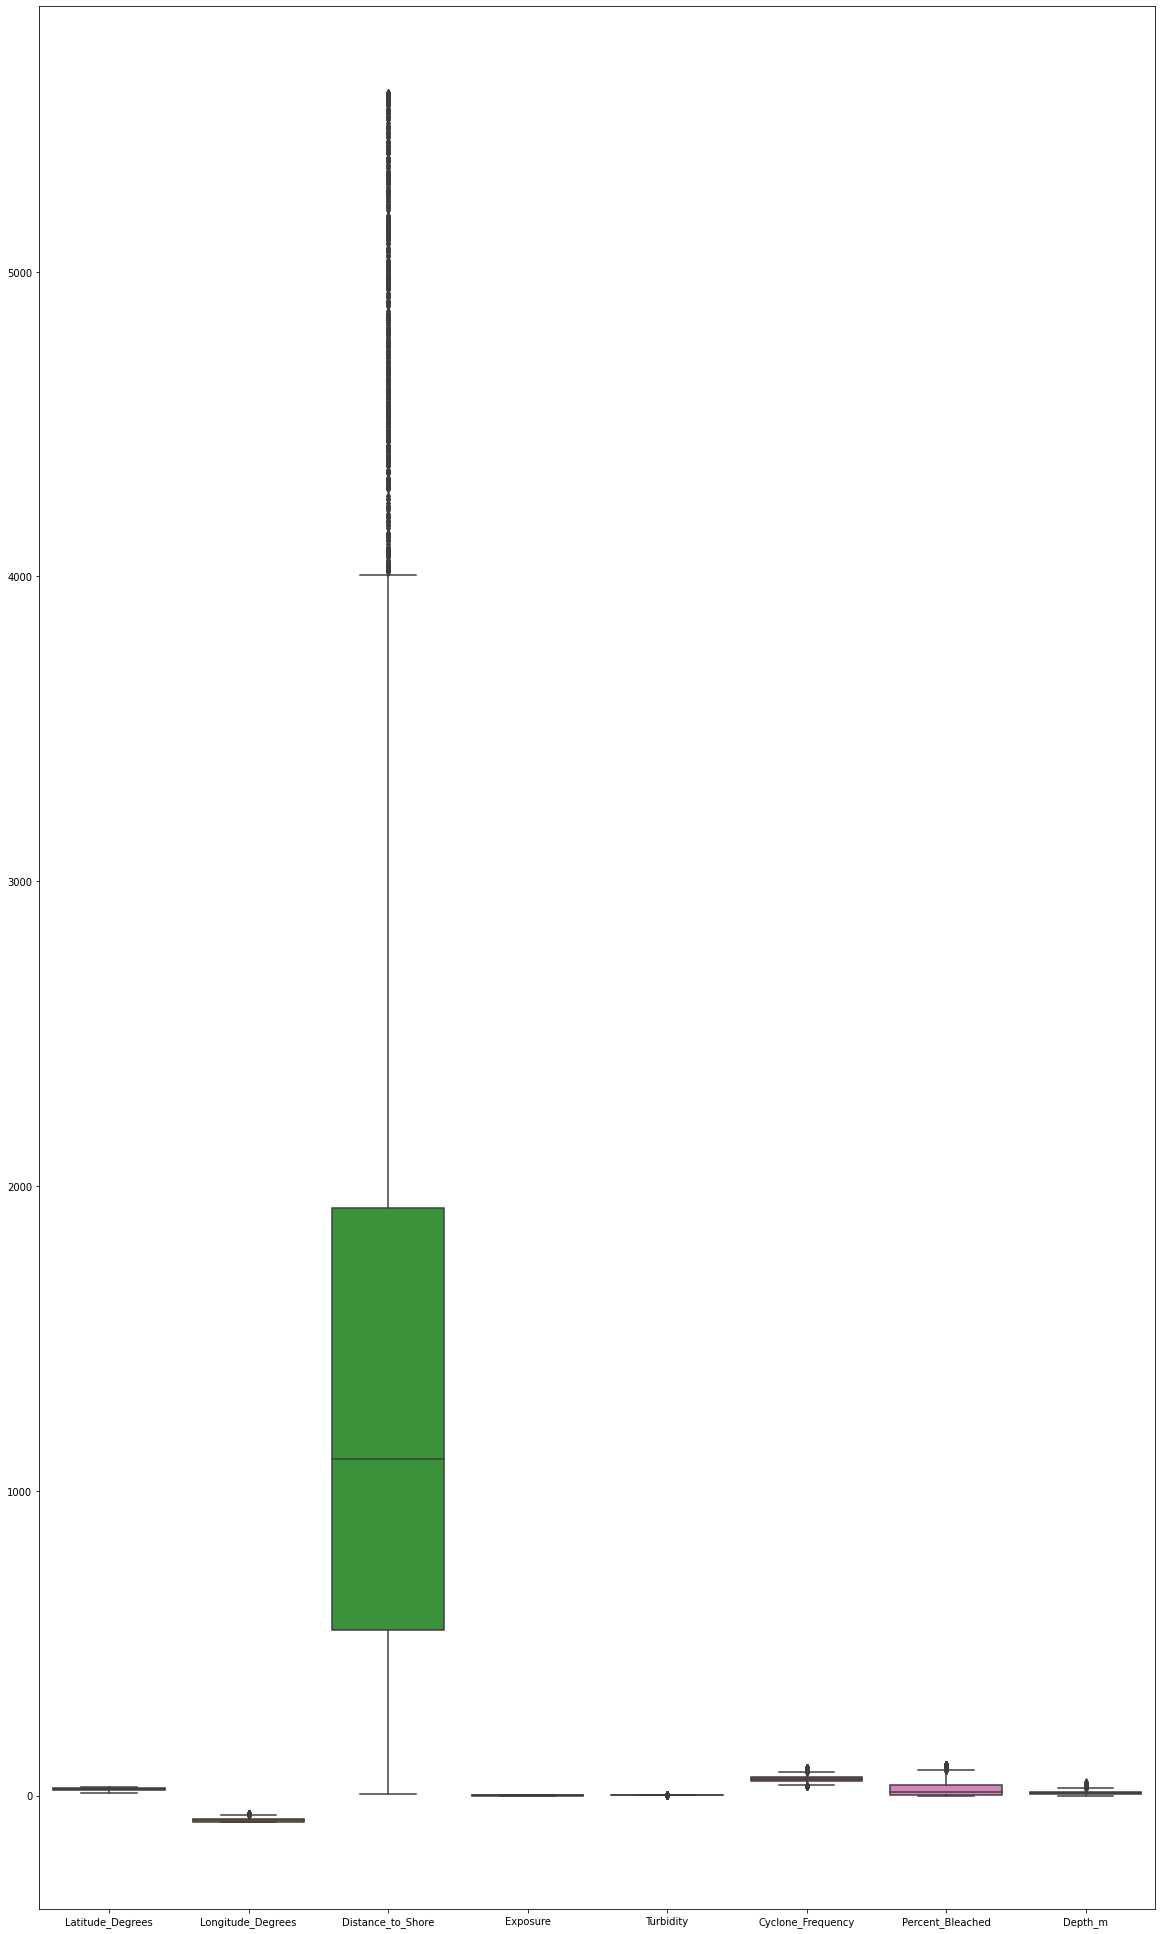

In [31]:
# Looking at outliers in the data - have some extreme outliers in distance to shore but should we still keep them?
plt.figure(figsize=(20,35))
sns.boxplot(data=bleaching_data)

,Latitude_Degrees,Longitude_Degrees,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Percent_Bleached,Depth_m
Latitude_Degrees,1.000000,-0.168340,0.356223,0.220269,0.090843,0.192177,-0.133759,-0.032652
Longitude_Degrees,-0.168340,1.000000,-0.180999,0.013131,0.016457,0.423527,0.155896,0.058435
Distance_to_Shore,0.356223,-0.180999,1.000000,-0.074497,0.348350,0.052797,-0.147079,-0.050443
Exposure,0.220269,0.013131,-0.074497,1.000000,-0.369730,-0.052627,0.143350,0.314001
Turbidity,0.090843,0.016457,0.348350,-0.369730,1.000000,0.088483,-0.142518,-0.320716
Cyclone_Frequency,0.192177,0.423527,0.052797,-0.052627,0.088483,1.000000,-0.032519,-0.099566
Percent_Bleached,-0.133759,0.155896,-0.147079,0.143350,-0.142518,-0.032519,1.000000,0.273347
Depth_m,-0.032652,0.058435,-0.050443,0.314001,-0.320716,-0.099566,0.273347,1.000000


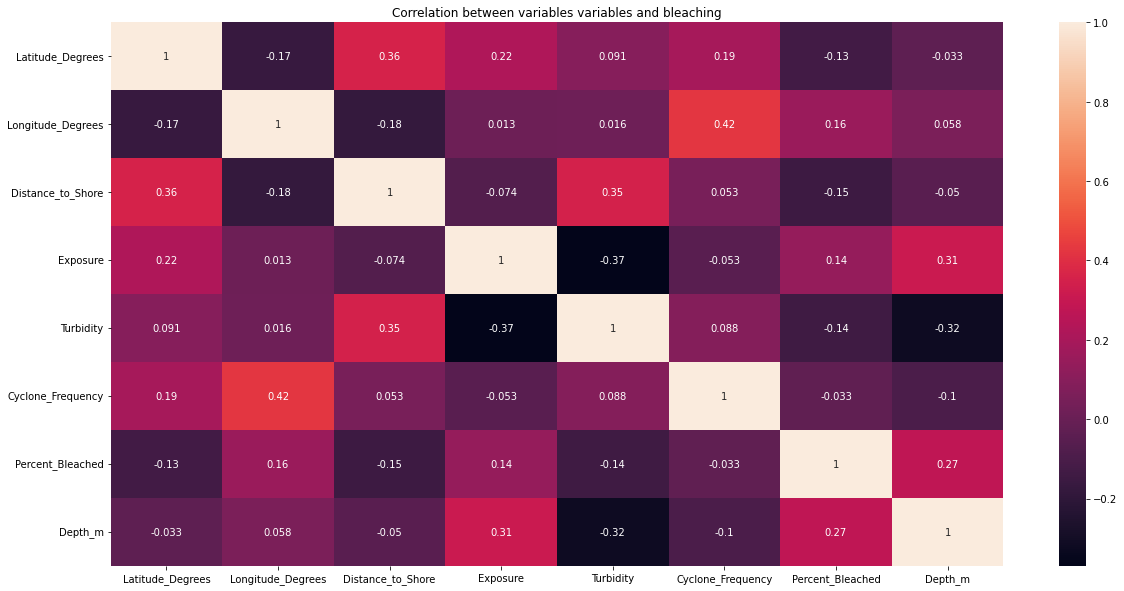

In [32]:
# looking at the correlation between the variables and the target lable
bleaching_corr = bleaching_data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(bleaching_corr, annot=True)
plt.title("Correlation between variables variables and bleaching")
bleaching_corr

When a value is closer to 0 there is no linear correlation between the two variables
closer to +1 there is a positive corr
closer to -1 there is a neagtive corr 

#### Distribution of data
Lets move on and looks at the Displots - showing the frequency distrubution and potential skew of each of the variables. 
The distribution of variables plays a role in the type of method we chosse to select for final features and in deature scaling

<Figure size 576x576 with 0 Axes>

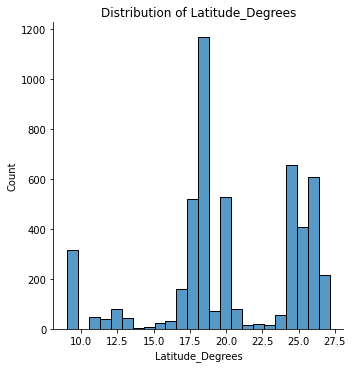

<Figure size 576x576 with 0 Axes>

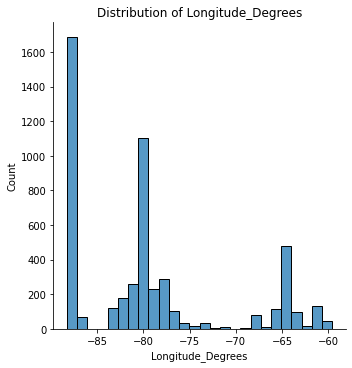

<Figure size 576x576 with 0 Axes>

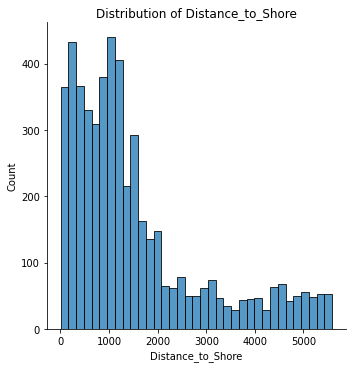

<Figure size 576x576 with 0 Axes>

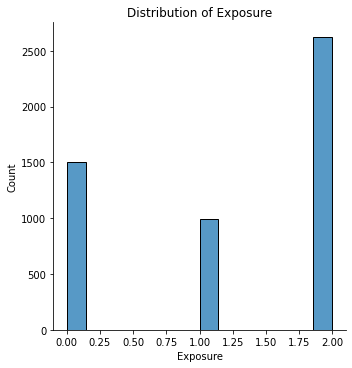

<Figure size 576x576 with 0 Axes>

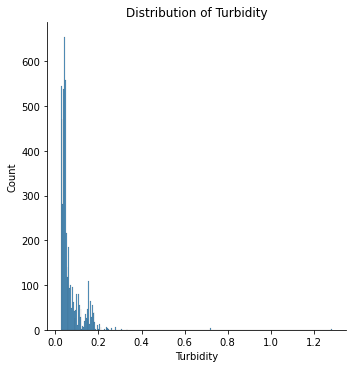

<Figure size 576x576 with 0 Axes>

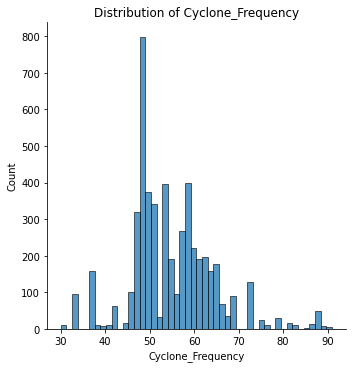

<Figure size 576x576 with 0 Axes>

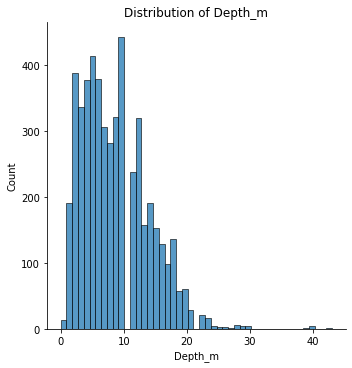

<Figure size 576x576 with 0 Axes>

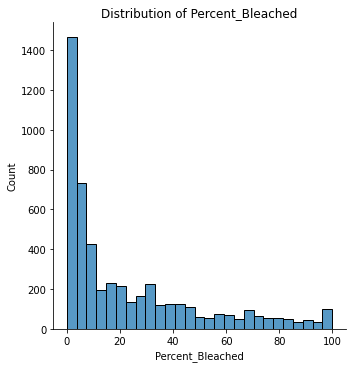

In [33]:
numeric_vars = ["Latitude_Degrees", "Longitude_Degrees", "Distance_to_Shore", "Exposure", "Turbidity", "Cyclone_Frequency", "Depth_m", "Percent_Bleached"]
for var in numeric_vars:
    plt.figure(figsize=(8,8))
    sns.displot(bleaching_data[var])
    plt.title(f"Distribution of {var}")
    plt.show()

In [42]:
bleaching_data = bleaching_data[np.abs(stats.zscore(bleaching_data["Turbidity"]) < 3)]

<Figure size 576x576 with 0 Axes>

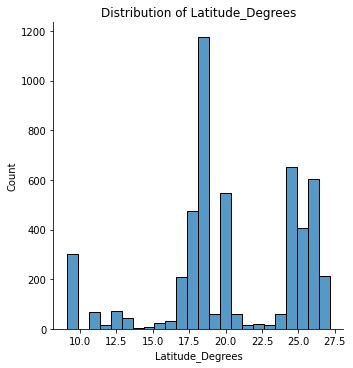

<Figure size 576x576 with 0 Axes>

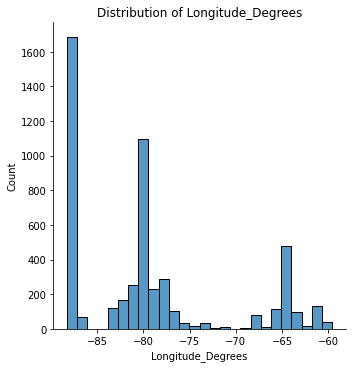

<Figure size 576x576 with 0 Axes>

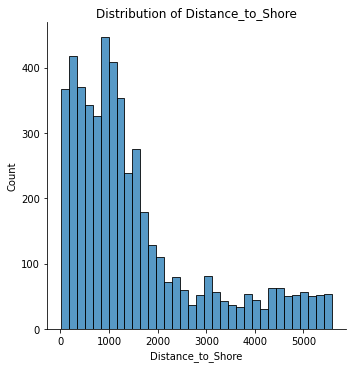

<Figure size 576x576 with 0 Axes>

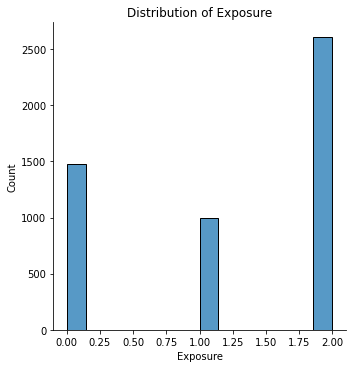

<Figure size 576x576 with 0 Axes>

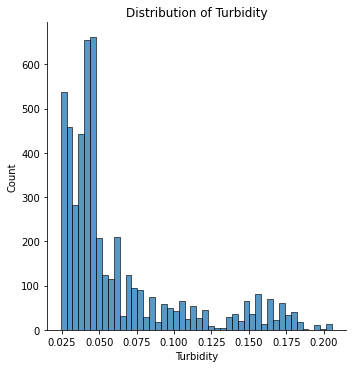

<Figure size 576x576 with 0 Axes>

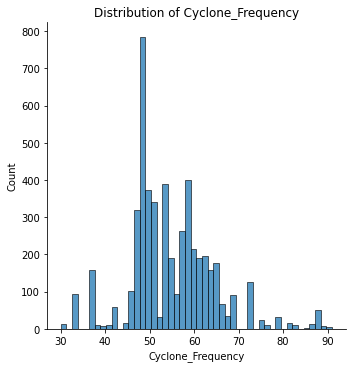

<Figure size 576x576 with 0 Axes>

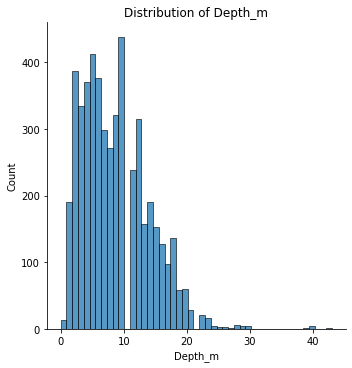

<Figure size 576x576 with 0 Axes>

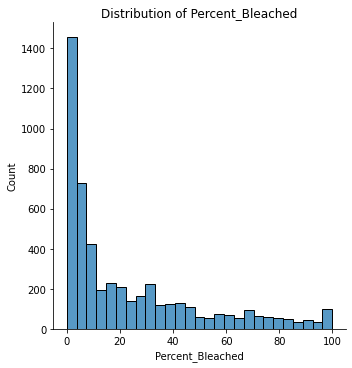

In [43]:
numeric_vars = ["Latitude_Degrees", "Longitude_Degrees", "Distance_to_Shore", "Exposure", "Turbidity", "Cyclone_Frequency", "Depth_m", "Percent_Bleached"]
for var in numeric_vars:
    plt.figure(figsize=(8,8))
    sns.displot(bleaching_data[var])
    plt.title(f"Distribution of {var}")
    plt.show()

Some reasoining on the data - what should we look for and not. Ideally scenario conatins norammly distributed data. Maybe move the outliers in ocean depth?

Let check the relationship between two categorical variables - what variables are more likely to contribute to the bleaching?

<AxesSubplot:xlabel='Cyclone_Frequency', ylabel='Percent_Bleached'>

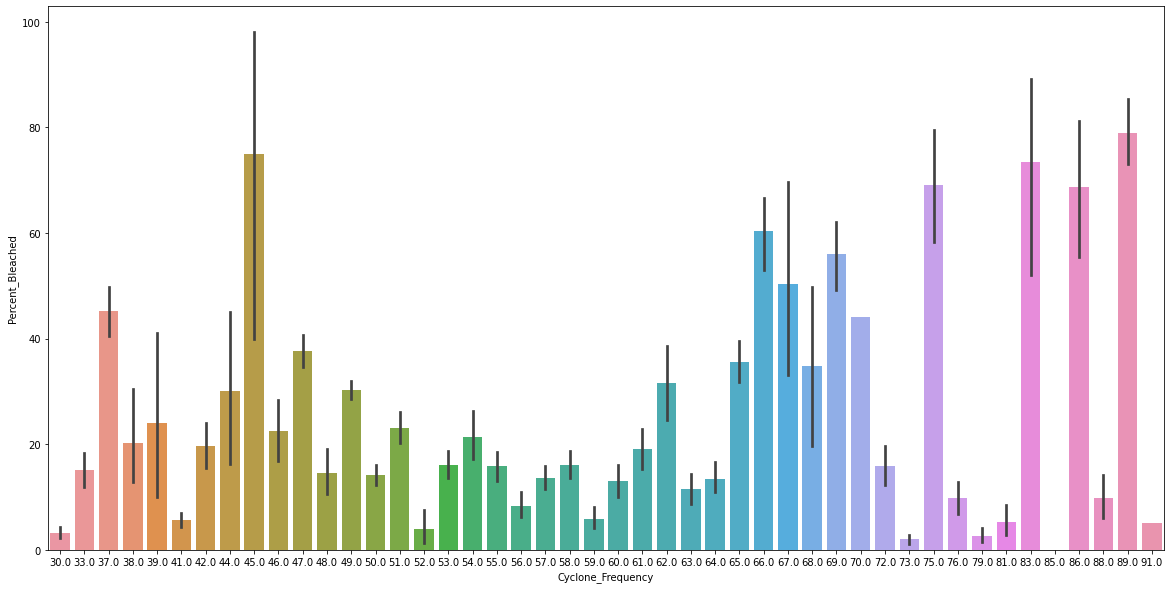

In [44]:
#Rounding data
bleaching_data["Percent_Bleached"] = bleaching_data["Percent_Bleached"].round(0)
bleaching_data["Cyclone_Frequency"] = bleaching_data["Cyclone_Frequency"].round(0)

plt.figure(figsize=(20,10))
sns.barplot(x=bleaching_data["Cyclone_Frequency"], y=bleaching_data["Percent_Bleached"])

<AxesSubplot:xlabel='Depth_m', ylabel='Percent_Bleached'>

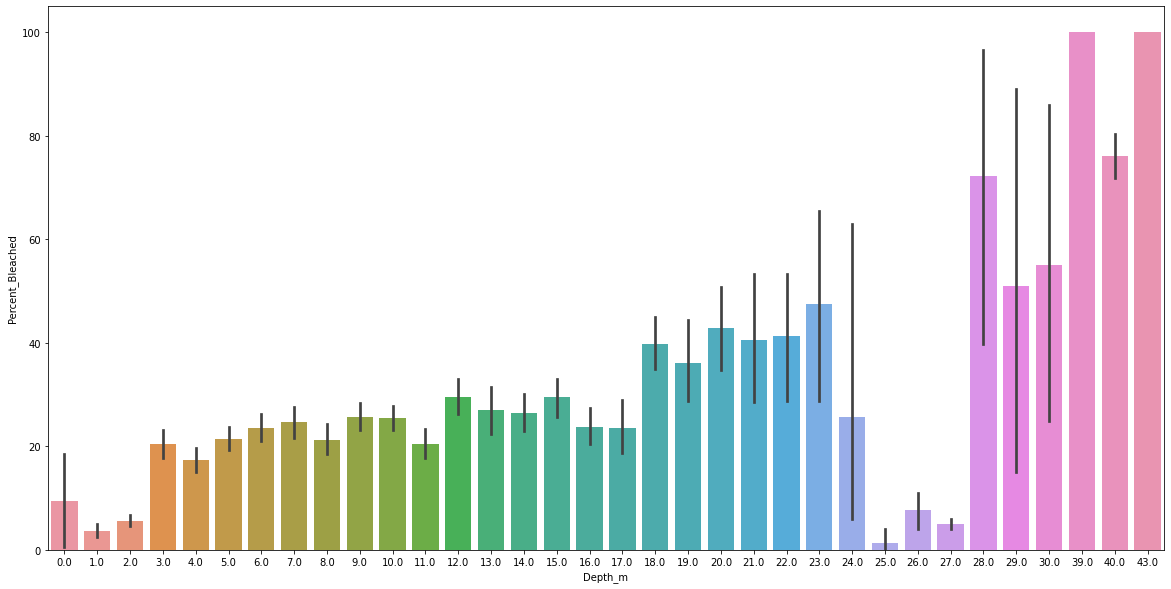

In [35]:
#Rounding data
bleaching_data["Depth_m"] = bleaching_data["Depth_m"].round(0)
plt.figure(figsize=(20,10))
sns.barplot(x=bleaching_data["Depth_m"], y=bleaching_data["Percent_Bleached"])

In [36]:
# Stragne one - only one value contributes to this - should either remove or keep. Lets check the count on the other values
bleaching_data[bleaching_data["Depth_m"] == 43]

,Latitude_Degrees,Longitude_Degrees,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Percent_Bleached,Depth_m
4218,17.624,-63.272,1423.0,1.0,0.0344,61.0,100.0,43.0


<AxesSubplot:xlabel='Distance_to_Shore', ylabel='Percent_Bleached'>

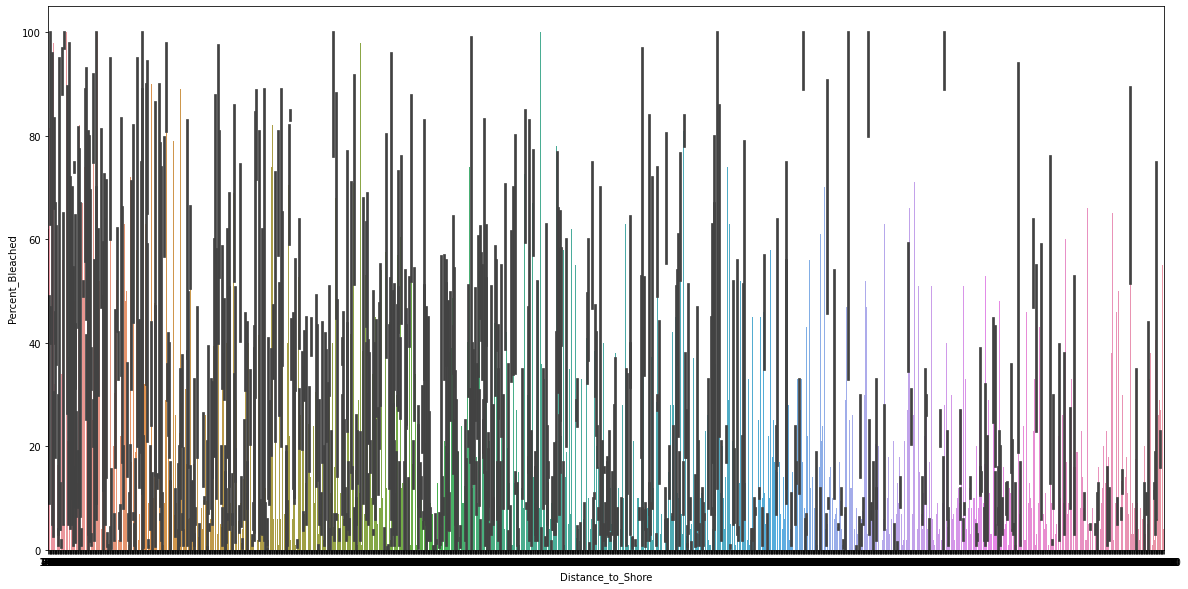

In [37]:
#numeric_vars = ["Latitude_Degrees", "Longitude_Degrees", "Distance_to_Shore", "Exposure", "Turbidity", "Cyclone_Frequency", "Depth_m", "Percent_Bleached"]
bleaching_data["Distance_to_Shore"] = bleaching_data["Distance_to_Shore"].round(0)

plt.figure(figsize=(20,10))
sns.barplot(x=bleaching_data["Distance_to_Shore"], y=bleaching_data["Percent_Bleached"])

In [21]:
# Messy plot should noramlize data?

Text(0.5, 1.0, 'Regression plot of Distance to shore and Percent Bleached')

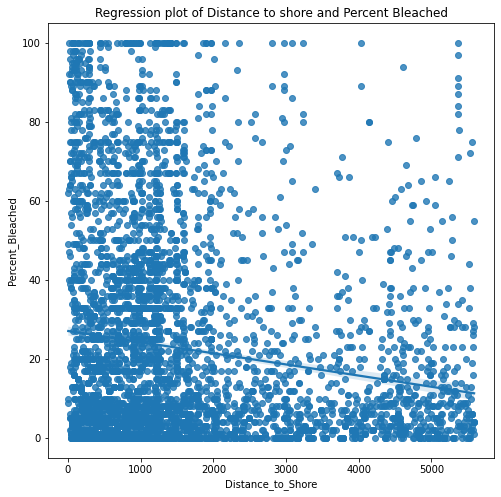

In [45]:
# trying to make a regression plot
plt.figure(figsize=(8,8))
sns.regplot(x=bleaching_data["Distance_to_Shore"], y=bleaching_data["Percent_Bleached"])
plt.title("Regression plot of Distance to shore and Percent Bleached")
# for those with good eyes one can see a falling trend

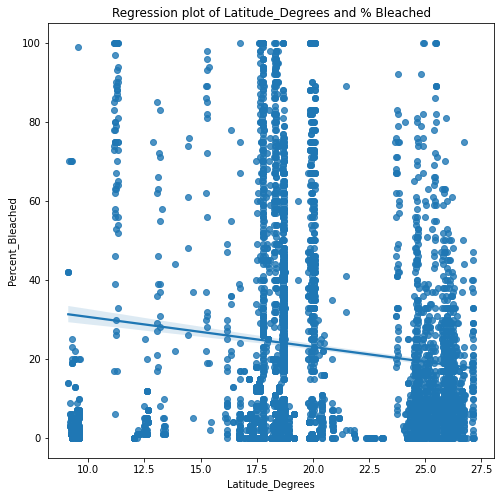

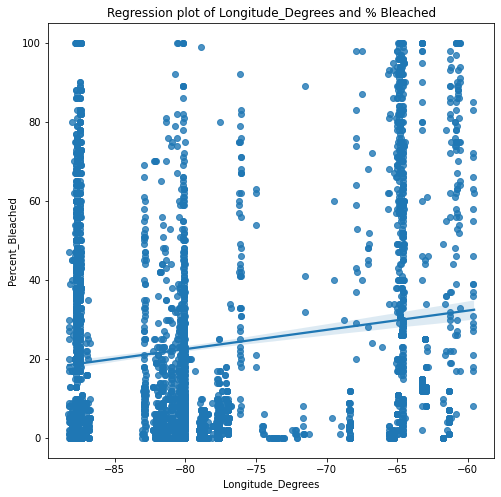

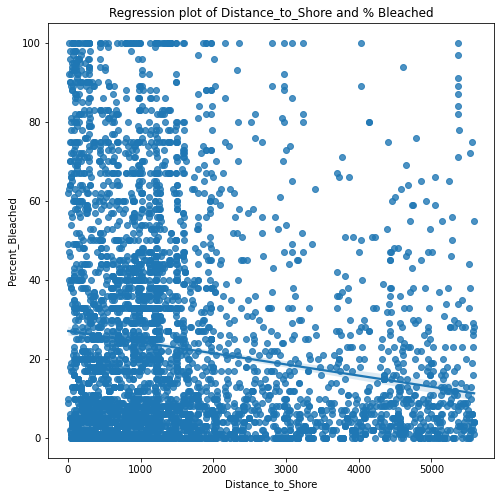

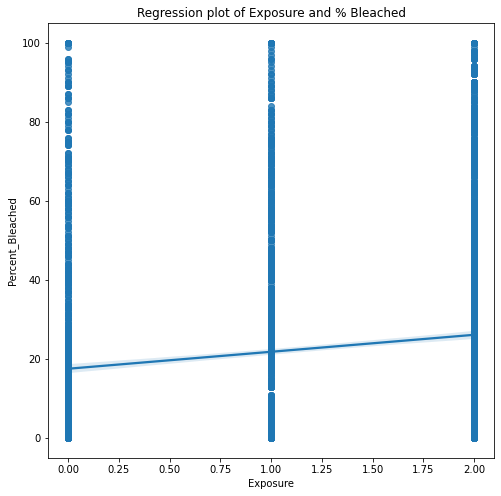

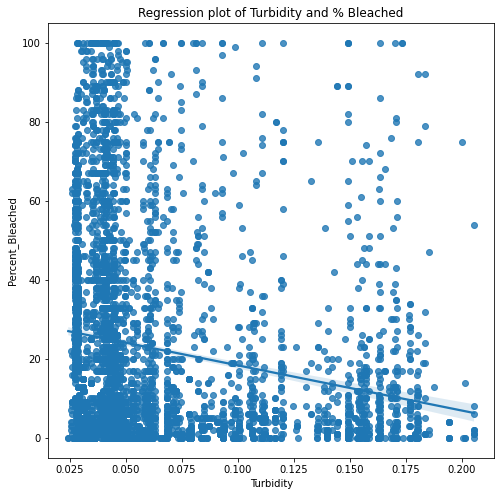

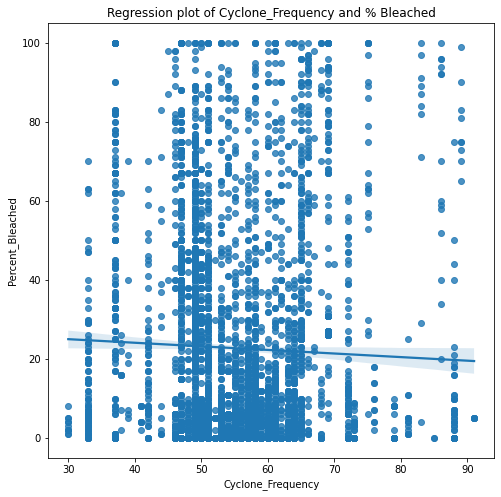

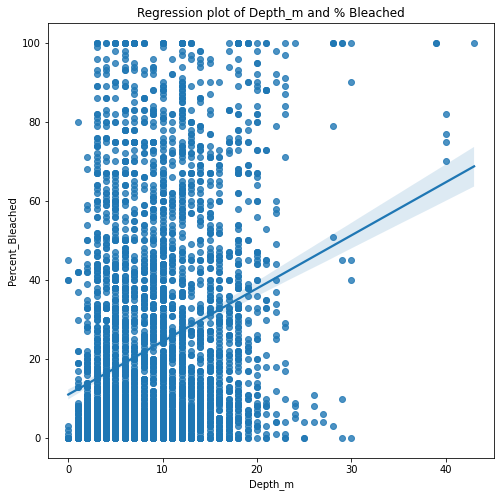

In [46]:
numeric_vars = ["Latitude_Degrees", "Longitude_Degrees", "Distance_to_Shore", "Exposure", "Turbidity", "Cyclone_Frequency", "Depth_m"]
for var in numeric_vars:
    plt.figure(figsize=(8,8))
    sns.regplot(x=bleaching_data[var], y=bleaching_data["Percent_Bleached"])
    plt.title(f"Regression plot of {var} and % Bleached")
    plt.show()

Now that we have an overview of our variabels lets choose some features for our ML model. We want to choose the features that directly influences the machine learning model. There are mutiple techinques to choose from

1. Select K Best - calculates the chi^2 statistics between each feature of X and Y class lables and reutens the first K features with the highest scores
2. Mutual info classification 
3. and many more :) 

In [65]:
from sklearn.feature_selection import SelectKBest, chi2
best_features_skb = SelectKBest(chi2, k=7)
bleaching_data_no_nan = bleaching_data.dropna(how='any',axis=0)
scaled_df =  bleaching_data_no_nan.copy()
for col in scaled_df.columns:
    max_value = scaled_df[col].max()
    min_value = scaled_df[col].min()
    scaled_df[col] = (scaled_df[col] - min_value) / (max_value - min_value)
# shold probably do this at the start
numeric_vars = ["Latitude_Degrees", "Longitude_Degrees", "Distance_to_Shore", "Exposure", "Turbidity", "Cyclone_Frequency", "Depth_m"]

# for this to work we need labels - considering evrything that is over 40% as bleached and everything below as not bleached
scaled_df["Bleached"] = scaled_df["Percent_Bleached"] > 0.4



fit_skb = best_features_skb.fit(scaled_df[numeric_vars], scaled_df["Bleached"])
dfscores = pd.DataFrame(fit_skb.scores_)
dfcolumns = pd.DataFrame(bleaching_data[numeric_vars].columns)

featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Specs", "Score"]
print(featureScores.nlargest(8, "Score"))

               Specs      Score
4          Turbidity  27.047524
1  Longitude_Degrees  20.669733
2  Distance_to_Shore  19.073618
6            Depth_m  15.092281
3           Exposure  14.000465
0   Latitude_Degrees  11.626980
5  Cyclone_Frequency   0.353129


Mutual info classifier - Measures dependency of features with the target variable, higher score indeicates more dependent variable

In [76]:
from sklearn.feature_selection import mutual_info_classif

threshold = 0.1
high_score_cols = []

feauture_scores = mutual_info_classif(scaled_df[numeric_vars], scaled_df["Bleached"], random_state=1)
for score, f_name in sorted(zip(feauture_scores, numeric_vars), reverse=True):
    if score > threshold:
        print(f_name, score)
        high_score_cols.append(f_name)

feature_scores_df = scaled_df[high_score_cols]


Latitude_Degrees 0.20865081781393724
Longitude_Degrees 0.201877311592916
Turbidity 0.14460299983371172
Distance_to_Shore 0.1408315894822305


Choosing top scoring features from the above 

In [78]:
selected_cols = ["Latitude_Degrees", "Longitude_Degrees","Turbidity", "Distance_to_Shore", "Depth_m"]
bleaching_data[selected_cols].head()

,Latitude_Degrees,Longitude_Degrees,Turbidity,Distance_to_Shore,Depth_m
13,23.796,-76.137,0.0392,272.0,4.0
14,24.650,-76.805,0.0444,426.0,3.0
15,24.650,-76.805,0.0444,426.0,3.0
16,24.650,-76.805,0.0444,426.0,3.0
21,24.170,-74.480,0.0293,5535.0,8.0


## Now that we have our features lets get going on the model <|:-)

1. Data pre-processing
2. Predicive model (logistic regresstion?)
3. Parameter tuning
4. Evaluate the model

In [84]:
# splitting our data set into test and train
from sklearn.model_selection import train_test_split
bleaching_data_no_nan["Bleached"] = bleaching_data_no_nan["Percent_Bleached"] > 40
x = bleaching_data_no_nan[selected_cols]
y = bleaching_data_no_nan["Bleached"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=25)

/var/folders/dm/9t1t7bzd1kb8cp21rjtzr97h0000gn/T/ipykernel_75750/1006238995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bleaching_data_no_nan["Bleached"] = bleaching_data_no_nan["Percent_Bleached"] > 40


In [85]:
# Feature scaling - all points should have the same weight. Using Min Max scalar assuming normal disribution of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Resampling imbalanced variable: Taking a look at the shape of the dataset before resampling, we see that our target variable, Bleached, is highly imbalanced. If we use this variable to predict, our models will favor the majority class and ignore the minority class resulting in models that have high accuracy but low recall. There’s a few ways to tackle this but we’ll use the [SMOTE]("https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7") method which oversamples the minority class by generating new samples from existing ones.

In [88]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1)
x_sm, y_sm = sm.fit_resample(x,y)
print(f'''Shape of X before SMOTE: {x.shape}
Shape of X after SMOTE: {x_sm.shape}''')
print('\nNumber of positive and negative instances in both classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (5049, 5)
Shape of X after SMOTE: (7988, 5)

Number of positive and negative instances in both classes (%):


False    50.0
True     50.0
Name: Bleached, dtype: float64

So far we’ve explored the dataset, identified and removed outliers, analyzed our categorical and numerical variables in depth, selected our features, appropriately divided our data into testing and training datasets, scaled our features, and balanced our target variable.
We are now ready for the machine learning algorithms.

#### Algorithms to use in classification problems
Logistic Regression, Random Forest, K-Nearest Neighbors and Support Vector Machines.

##### Logistic Regression
Widely used classification algorithm when the expected output is binary (yes/no or 0/1). This algorithm proves helpful when understanding the influence of one or more independent variables to a single outcome variable.

In [140]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report
bleaching_lr = LogisticRegression(random_state=25, max_iter=100)
lr_model = bleaching_lr.fit(x_train, y_train) 
lr_predict = bleaching_lr.predict(x_test)
lr_accuracy = accuracy_score(y_test, lr_predict) 
lr_cm = confusion_matrix(y_test, lr_predict)
lr_dct = {"Model": "Logistic Regression", "Accuracy": lr_accuracy, "Confusion Matrix": lr_cm}
print("Accuracy of Logistic Regression:", lr_accuracy)
print("Logistic Regression Confusion Matrix:", lr_cm)
print(classification_report(y_test, lr_predict))

Accuracy of Logistic Regression: 0.7960396039603961
Logistic Regression Confusion Matrix: [[798   2]
 [204   6]]
              precision    recall  f1-score   support

       False       0.80      1.00      0.89       800
        True       0.75      0.03      0.06       210

    accuracy                           0.80      1010
   macro avg       0.77      0.51      0.47      1010
weighted avg       0.79      0.80      0.71      1010



Text(0.5, 1.0, 'Accuracy Score: 0.7960396039603961')

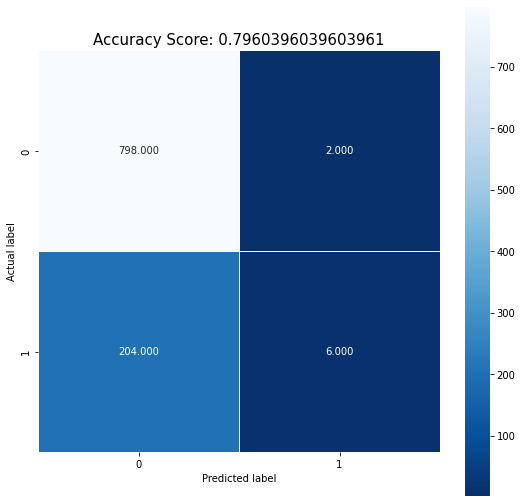

In [93]:
plt.figure(figsize=(9,9))
sns.heatmap(lr_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(lr_accuracy)
plt.title(all_sample_title, size = 15)

#### Random Forest 
Effective for both classification and regression problems, a random forest is several decision trees put together. What’s a decision tree? Similar looking to a flowchart, a decision tree breaks down data into smaller subsets until the algorithm finds the smallest tree that fits the data. Although individual trees are easy to interpret and handle data well, they are prone to overfitting and produce results with low accuracy. Bringing together multiple trees into a model i.e., Random Forest enhances the performance of each individual tree model into one strong tree model.

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report
rf = RandomForestClassifier(n_estimators=100, random_state=25, max_depth=12)
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predict)
rf_cm = confusion_matrix(y_test, rf_predict)
rf_dct = {"Model": "Random forsest","Accuracy": rf_accuracy, "Confusion Matrix": rf_cm}
print("Accuracy of Random Forest:", rf_accuracy)
print("Random Forest Confusion Matrix:", rf_cm)
print(classification_report(y_test, rf_predict))


Accuracy of Random Forest: 0.8435643564356435
Random Forest Confusion Matrix: [[738  62]
 [ 96 114]]
              precision    recall  f1-score   support

       False       0.88      0.92      0.90       800
        True       0.65      0.54      0.59       210

    accuracy                           0.84      1010
   macro avg       0.77      0.73      0.75      1010
weighted avg       0.84      0.84      0.84      1010



#### K-Nearest Neighbors: 
This algorithm operates under the assumption that similar data points exist near each other. KNN combines this idea of ‘closeness’ to calculate the distance between data points. Taking a specific value for K, for example K = 5, we’d consider the 5 closest data points to the unknown data point and the majority label between these points would be assigned to the unknown data point.

In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report
knn = KNeighborsClassifier(n_neighbors=5)
knn_model = knn.fit(x_train, y_train)
knn_predict = knn.predict(x_test)
knn_cm = confusion_matrix(y_test, knn_predict)
knn_accuracy = accuracy_score(y_test, knn_predict)
print("Accuracy of KNN Classification:", knn_accuracy)
print("KNN Classification Confusion Matrix:", knn_cm)
knn_dct = {"Model": "K-Nearest Neighbour","Accuracy": knn_accuracy, "Confusion Matrix": knn_cm}
print(classification_report(y_test, knn_predict))

Accuracy of KNN Classification: 0.8267326732673267
KNN Classification Confusion Matrix: [[720  80]
 [ 95 115]]
              precision    recall  f1-score   support

       False       0.88      0.90      0.89       800
        True       0.59      0.55      0.57       210

    accuracy                           0.83      1010
   macro avg       0.74      0.72      0.73      1010
weighted avg       0.82      0.83      0.82      1010



#### Support Vector Machine: 
This algorithm creates a linear separator that divides the group of data points into two classes (for classification), classifying each data point into one of the two classes.


In [143]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, classification_report
svm = SVC()
svm_model = svm.fit(x_train, y_train)
svm_predict = svm.predict(x_test)
svm_cm = confusion_matrix(y_test, svm_predict)
svm_accuracy = accuracy_score(y_test, svm_predict)
svm_dct = {"Model": "Support Vector Machine", "Accuracy": svm_accuracy, "Confusion Matrix": svm_cm}
print("Accuracy of SVM Classification:", svm_accuracy)
print("SVM Classification Confusion Matrix:", svm_cm)
print(classification_report(y_test, svm_predict))


# TODO - add a plot to this?

Accuracy of SVM Classification: 0.801980198019802
SVM Classification Confusion Matrix: [[797   3]
 [197  13]]
              precision    recall  f1-score   support

       False       0.80      1.00      0.89       800
        True       0.81      0.06      0.12       210

    accuracy                           0.80      1010
   macro avg       0.81      0.53      0.50      1010
weighted avg       0.80      0.80      0.73      1010



Summary of models:

In [145]:
model_summary = pd.DataFrame([lr_dct, rf_dct, knn_dct, svm_dct])
model_summary

,Model,Accuracy,Confusion Matrix
0,Logistic Regression,0.796040,"[[798, 2], [204, 6]]"
1,Random forsest,0.843564,"[[738, 62], [96, 114]]"
2,K-Nearest Neighbour,0.826733,"[[720, 80], [95, 115]]"
3,Support Vector Machine,0.801980,"[[797, 3], [197, 13]]"


## Challenge
Tune the different machine learnings models to see if you can increase its classification accuracy

In [ ]:
# TODO  - Hyper parameter tuning
# TODO - remove lat and lon as we have already selected area - how will this affect the accuracy?